# Power Consumption Exploration of HTCC AB01

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [103]:
power_df = pd.read_csv('ppk2.csv')
power_df = power_df.rename(columns={'Timestamp(ms)': 'time', 'Current(uA)': 'current'})

# ppk2 for some reason warps time... I measured it and it's timestamps occur approximately 1/3 slower than they should.
# I have found external validation that my assumption is correct: https://devzone.nordicsemi.com/f/nordic-q-a/103942/ppk2-wrong-time-scale-and-how-to-work-around-it
dilation = 3
power_df['time'] = power_df['time']/(10**3)*dilation
power_df['current'] = power_df['current']/(10**3)

power_df.head()

,time,current
0,0.00000,0.0
1,0.00003,0.0
2,0.00006,0.0
3,0.00009,0.0
4,0.00012,0.0


In [77]:
cutoff = 12.5 * dilation

joining_times = power_df['time'][power_df['time'] < cutoff]
joining_currents = power_df['current'][power_df['time'] < cutoff]

sending_times = power_df['time'][power_df['time'] >= cutoff]
sending_currents = power_df['current'][power_df['time'] >= cutoff]

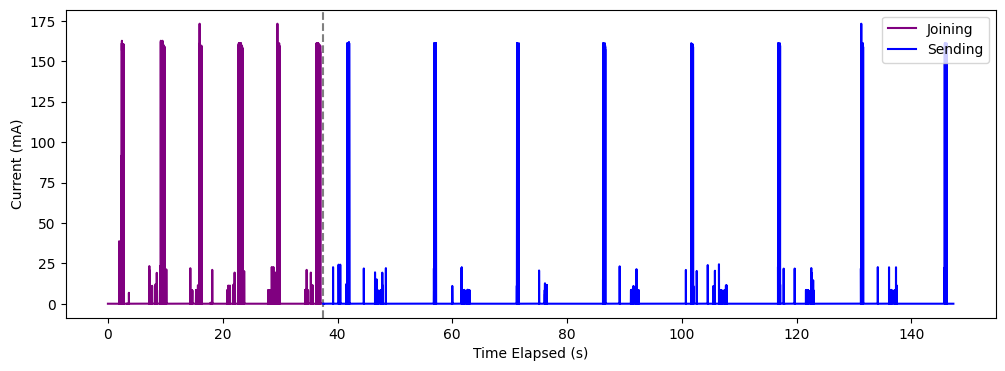

In [341]:
# Power profile

plt.figure(figsize=(12, 4))
plt.plot(joining_times, joining_currents, color='purple', label='Joining')
plt.axvline(x=cutoff, color='gray', linestyle='--')
plt.plot(sending_times, sending_currents, color='blue', label='Sending')

# plt.title('Power Profile of HTCC AB01 during LoRaWan Transmission')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper right')

plt.savefig('power_profile.png', transparent=True)
plt.show()

In [94]:
# Total consumption of HTCC AB01 during both portions

auc = np.trapz(power_df['current'], power_df['time'])
print(f"AUC: {auc.round(3)} mA*s")
print(f"New operating at 3.3V: {round(3.3 * auc/1000, 3)} J")

AUC: 278.587 mA*s
New operating at 3.3V: 0.919 J
Old idling at 3.3V: 1.485 J


In [93]:
# Total consumption of HTCC AB01 during send portion

sending_auc = np.trapz(sending_currents, sending_times)
print(f"AUC: {sending_auc.round(3)} mA*s")
print(f"New operating at 3.3V: {round(3.3 * sending_auc/1000, 3)} J")

AUC: 76.219 mA*s
New operating at 3.3V: 0.252 J


In [92]:
# Total consumption of HTCC AB01 during send portion

joining_auc = np.trapz(joining_currents, joining_times)
print(f"AUC: {joining_auc.round(3)} mA*s")
print(f"New operating at 3.3V: {round(3.3 * joining_auc/1000, 3)} J")

AUC: 202.367 mA*s
New operating at 3.3V: 0.668 J


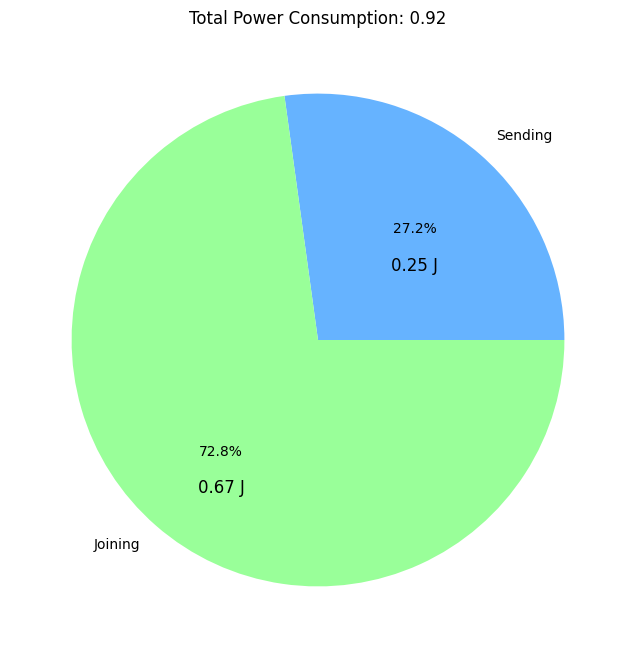

In [383]:
# Proportions of power usage

labels = ['Sending', 'Joining']
portions = [round(3.3 * sending_auc/1000, 2), round(3.3 * joining_auc/1000, 2)]
colors = ['#66b3ff', '#99ff99']

plt.figure(figsize=(8, 8))
plt.pie(portions, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
# plt.title('Sending vs. Joining Power Consumption Portions')
plt.title(f'Total Power Consumption: {round(portions[0]+portions[1], 2)}')

plt.text(0.39, 0.3, f'{portions[0]} J', ha='center', va='center', fontsize=12)
plt.text(-0.39, -0.6, f'{portions[1]} J', ha='center', va='center', fontsize=12)

plt.savefig('power_percentages.png', transparent=True)

plt.show()

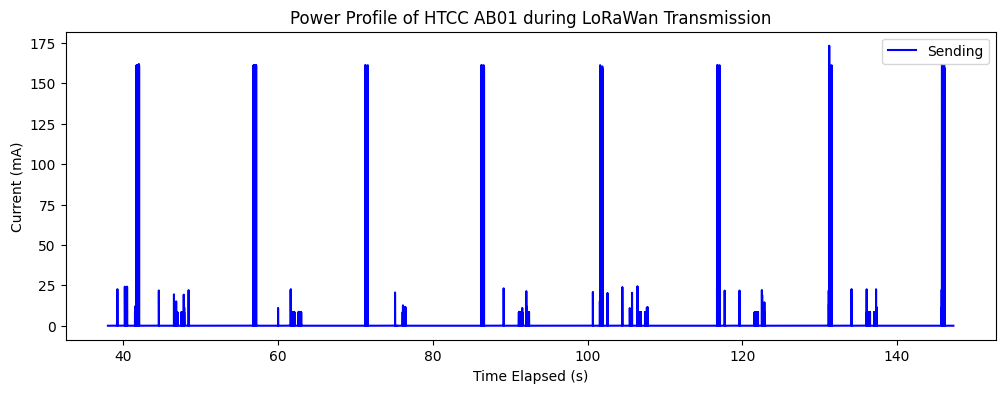

In [126]:
# Plot just the sending portion

start = 38
stop = 150

filtered_data = power_df.loc[(power_df['time'] > start) & (power_df['time'] < stop), ['time', 'current']]

plt.figure(figsize=(12, 4))
plt.plot(filtered_data['time'], filtered_data['current'], color='blue', label='Sending')

plt.title('Power Profile of HTCC AB01 during LoRaWan Transmission')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper right')
plt.show()

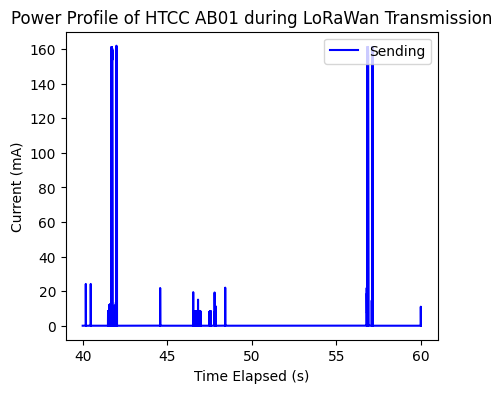

In [279]:
start = 40
stop = 60

filtered_data = power_df.loc[(power_df['time'] > start) & (power_df['time'] < stop), ['time', 'current']]

plt.figure(figsize=(4.8, 4))
plt.plot(filtered_data['time'], filtered_data['current'], color='blue', label='Sending')

plt.title('Power Profile of HTCC AB01 during LoRaWan Transmission')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper right')
plt.show()

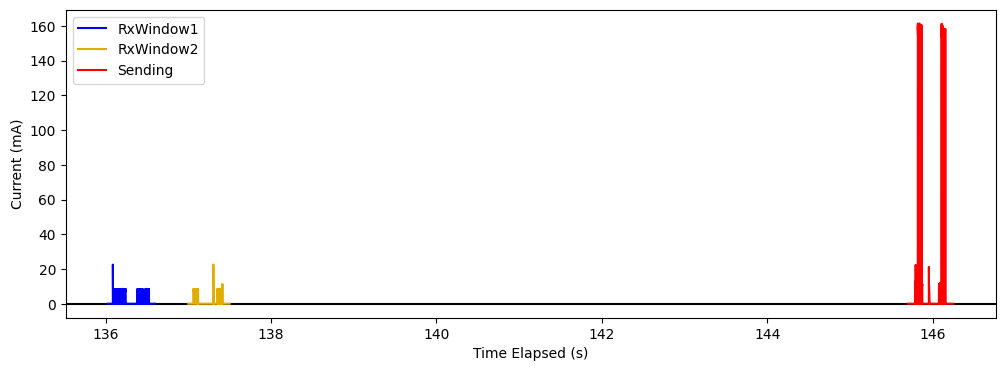

In [386]:
# Isolating one sending period -- note that there is a 15s duty cycle that we can manipulate

blue_data = power_df.loc[(power_df['time'] > 136.03) & (power_df['time'] < 136.6), ['time', 'current']]
yellow_data = power_df.loc[(power_df['time'] > 137) & (power_df['time'] < 137.5), ['time', 'current']]
red_data = power_df.loc[(power_df['time'] > 145.7) & (power_df['time'] < 146.25), ['time', 'current']]

plt.figure(figsize=(12, 4))
plt.axhline(y=0, color='black')
plt.plot(blue_data['time'], blue_data['current'], color='blue', label='RxWindow1')
plt.plot(yellow_data['time'], yellow_data['current'], color='#E1AD01', label='RxWindow2')
plt.plot(red_data['time'], red_data['current'], color='red', label='Sending')

# plt.title('Power Profile of HTCC AB01 during Send Cycle')
plt.xlabel('Time Elapsed (s)')
plt.ylabel('Current (mA)')
plt.legend(loc='upper left')

plt.savefig('single_cycle.png', transparent=True)

plt.show()

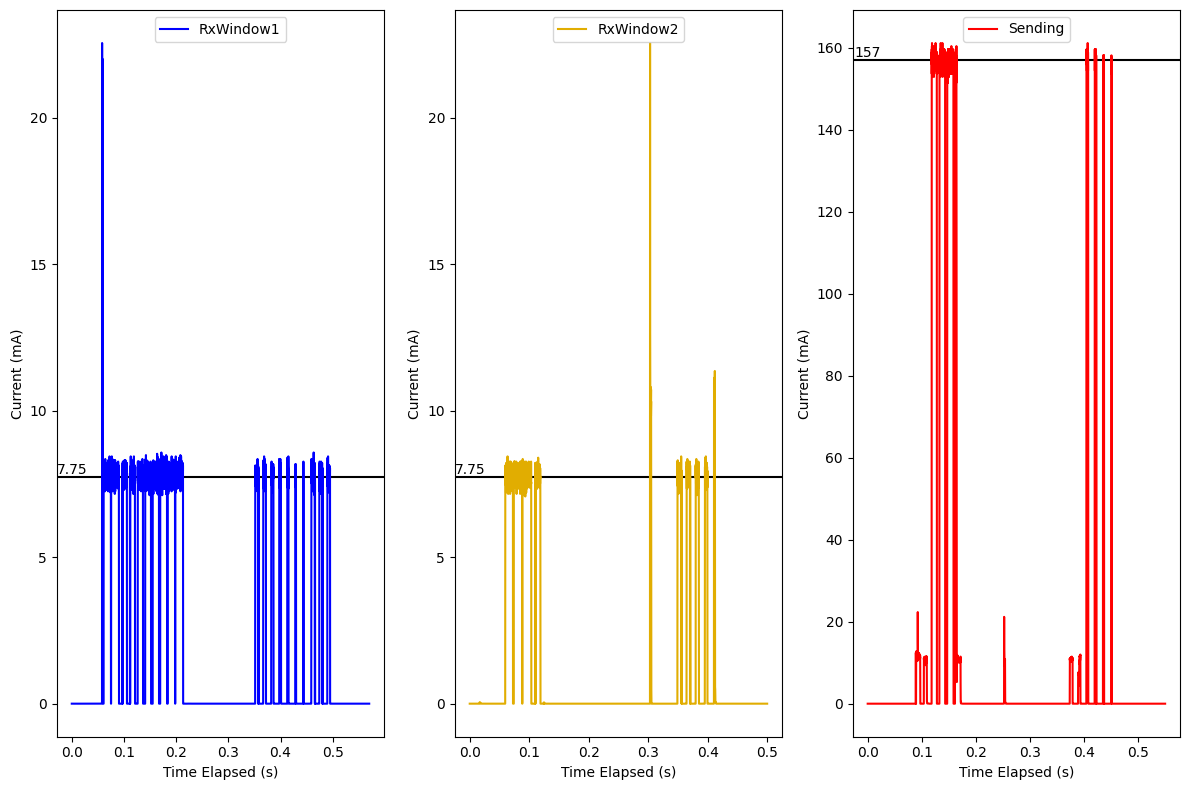

In [384]:
# Plot individual portions side-by-side

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

axes[0].axhline(y=7.75, color='black')
axes[0].plot(blue_data['time']-blue_data['time'].min(), blue_data['current'], color='blue', label='RxWindow1')
axes[0].text(0, 7.75, '7.75', verticalalignment='bottom', horizontalalignment='center')
axes[0].set_xlabel('Time Elapsed (s)')
axes[0].set_ylabel('Current (mA)')
axes[0].legend(loc='upper center')

axes[1].axhline(y=7.75, color='black')
axes[1].plot(yellow_data['time']-yellow_data['time'].min(), yellow_data['current'], color='#E1AD01', label='RxWindow2')
axes[1].text(0, 7.75, '7.75', verticalalignment='bottom', horizontalalignment='center')
axes[1].set_xlabel('Time Elapsed (s)')
axes[1].set_ylabel('Current (mA)')
axes[1].legend(loc='upper center')

axes[2].axhline(y=157, color='black')
axes[2].plot(red_data['time']-red_data['time'].min(), red_data['current'], color='red', label='Sending')
axes[2].text(0, 157, '157', verticalalignment='bottom', horizontalalignment='center')
axes[2].set_xlabel('Time Elapsed (s)')
axes[2].set_ylabel('Current (mA)')
axes[2].legend(loc='upper center')

# fig.suptitle("Individual Power Profiles of Each Send Cycle Component", y=1.02, fontsize=16)
plt.tight_layout()

plt.savefig('individual_profiles.png', transparent=True)

plt.show()

In [281]:
# Calculate AUC for each color
blue_auc = np.trapz(blue_data['current'], x=blue_data['time'])
yellow_auc = np.trapz(yellow_data['current'], x=yellow_data['time'])
red_auc = np.trapz(red_data['current'], x=red_data['time'])
black_auc = (3.75*10**(-3))*15

# Print AUCs
print(f"Blue AUC: {blue_auc.round(3)} mA*s")
print(f"Yellow AUC: {yellow_auc.round(3)} mA*s")
print(f"Red AUC: {red_auc.round(3)} mA*s")
print(f"Black AUC: {round(black_auc, 3)} mA*s")

# Approximate time on
print(f"\nBlue time: {blue_auc/7.75} s")
print(f"Yellow time: {yellow_auc/7.75} s")
print(f"Red time: {red_auc/157} s")

# Print power consumptions
print(f"\nBlue at 3.3V: {round(3.3 * blue_auc/1000, 3)} J")
print(f"Yellow at 3.3V: {round(3.3 * yellow_auc/1000, 3)} J")
print(f"Red at 3.3V: {round(3.3 * red_auc/1000, 3)} J")
print(f"Black at 3.3V: {round(3.3 * black_auc/1000, 3)} J")

Blue AUC: 1.294 mA*s
Yellow AUC: 0.609 mA*s
Red AUC: 7.154 mA*s
Black AUC: 0.056 mA*s

Blue time: 0.1669359951947784 s
Yellow time: 0.07861772204709747 s
Red time: 0.04556510368870368 s

Blue at 3.3V: 0.004 J
Yellow at 3.3V: 0.002 J
Red at 3.3V: 0.024 J
Black at 3.3V: 0.0 J


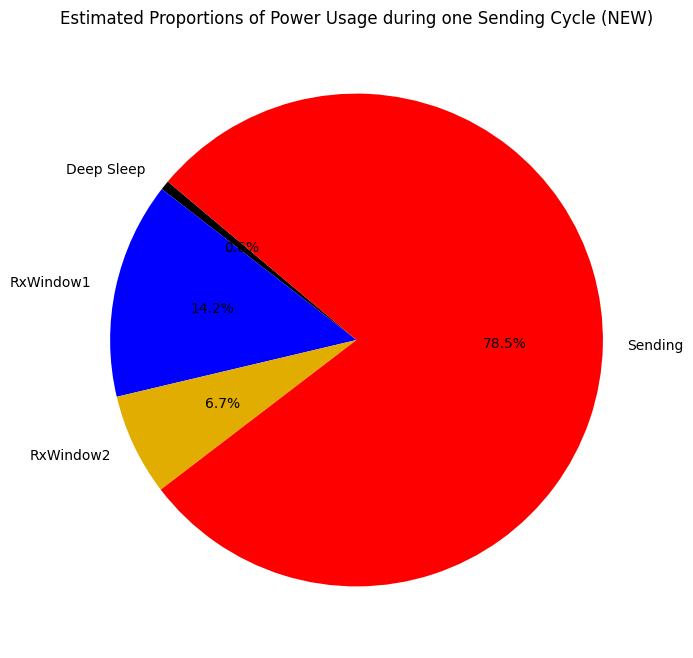

In [285]:
# Estimated proportions of power usage in one sending cycle (same as AUC proportions)

labels = ['Deep Sleep', 'RxWindow1', 'RxWindow2', 'Sending']
portions = [black_auc, blue_auc, yellow_auc, red_auc]
colors = ['black', 'blue', '#E1AD01', 'red']

plt.figure(figsize=(8, 8))
plt.pie(portions, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Estimated Proportions of Power Usage during one Sending Cycle (NEW)')
plt.show()

The old report has some weird methodology when it comes down to power usage for each sending cycle component. 

They take an average peak of each component and multiply it by 1s, rather than giving specific on times. 

Let's just compare the peaks and assume the on times are similar.

There is also no data on the joining portion, so we will skip this comparison.

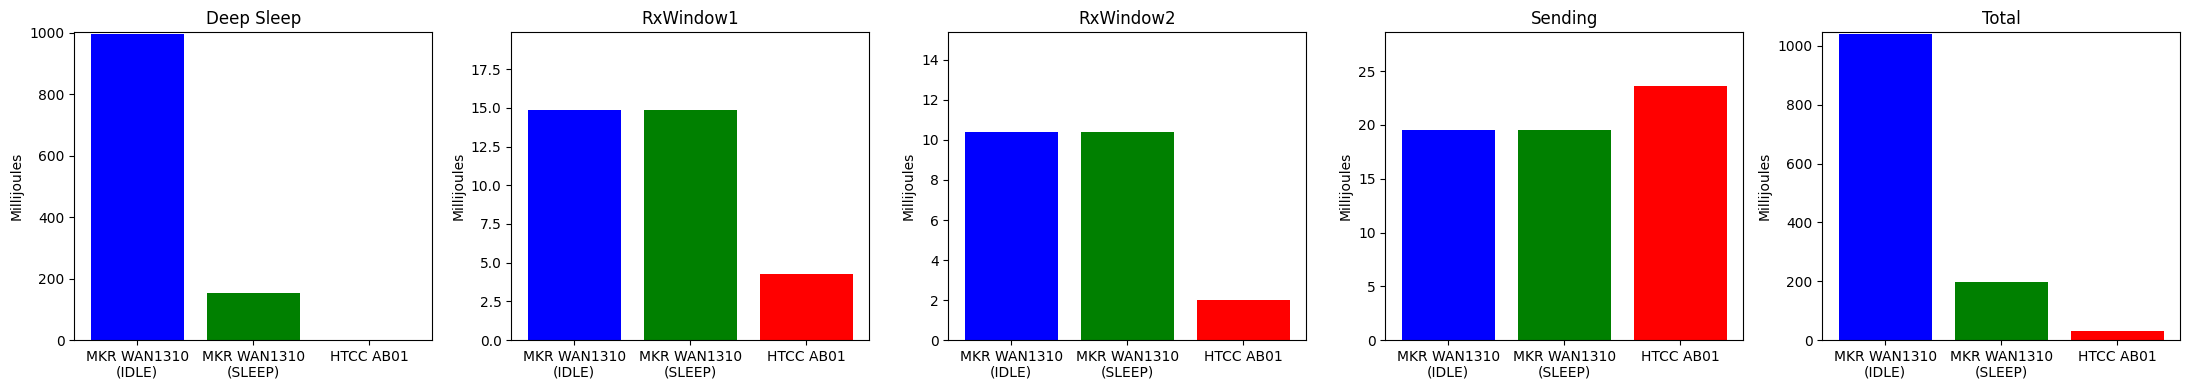

In [388]:
# Making very generous assumptions about the previous chip's data, since I don't have the actual datasets. Just going off of what the student said. Margins are probably better than this even.

labels = ['Deep Sleep', 'RxWindow1', 'RxWindow2', 'Sending', 'Total']
new_peaks = np.array([3.3*3.75*10**(-3)*15, 3.3*7.75*0.1669359951947784, 3.3*7.75*0.07861772204709747, 3.3*157*0.04556510368870368])
old_peaks = np.array([3.3*3.08*15, 3.3*27*0.1669359951947784, 3.3*40*0.07861772204709747, 3.3*130*0.04556510368870368])
old_bad_peaks = np.array([3.3*20.13*15, 3.3*27*0.1669359951947784, 3.3*40*0.07861772204709747, 3.3*130*0.04556510368870368])
new_peaks = np.append(new_peaks, new_peaks.sum())
old_peaks = np.append(old_peaks, old_peaks.sum())
old_bad_peaks = np.append(old_bad_peaks, old_bad_peaks.sum())


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(22, 4))

for i, (label, new_peak, old_peak, old_bad_peak) in enumerate(zip(labels, new_peaks, old_peaks, old_bad_peaks)):
    axes[i].bar(['MKR WAN1310\n(IDLE)', 'MKR WAN1310\n(SLEEP)', 'HTCC AB01'], [old_bad_peak, old_peak, new_peak], color=['blue', 'green', 'red'])
    axes[i].set_title(label)
    axes[i].set_ylabel('Millijoules')
    axes[i].set_ylim(0, max(new_peak, old_bad_peak, old_peak)+5)

# plt.suptitle('Comparing Power Consumption Amounts', y=1.05, fontsize=16)
plt.tight_layout()

plt.savefig('consumption_amounts.png', transparent=True)

plt.show()


In [325]:
# Make a dataframe for numerical comparison

df = pd.DataFrame({
    'Labels': labels,
    'Old (IDLE) mJ': old_bad_peaks.round(3),
    'Old (SLEEP) mJ': old_peaks.round(3),
    'New mJ': new_peaks.round(3)
})

df


,Labels,Old (IDLE) mJ,Old (SLEEP) mJ,New mJ
0,Deep Sleep,996.435,152.460,0.186
1,RxWindow1,14.874,14.874,4.269
2,RxWindow2,10.378,10.378,2.011
3,Sending,19.547,19.547,23.607
4,Total,1041.234,197.259,30.073


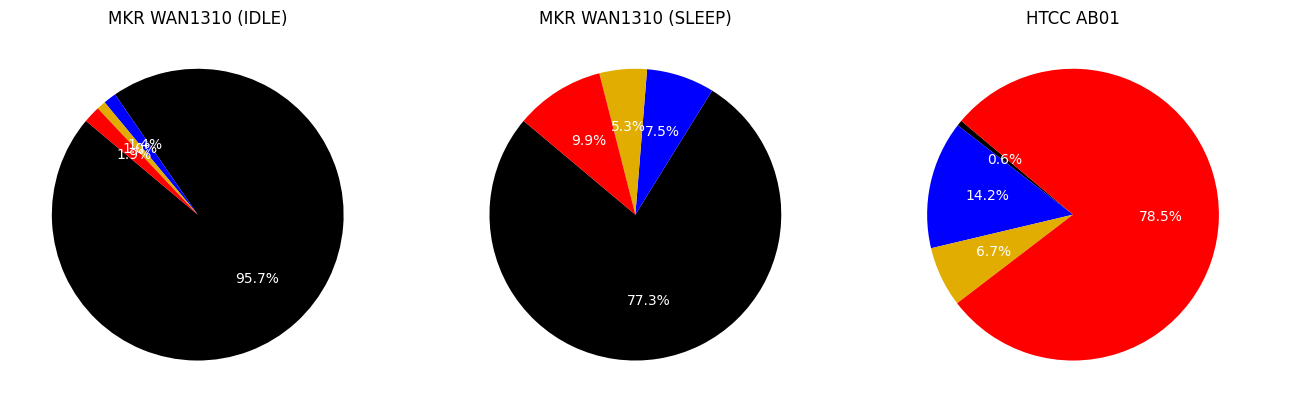

In [340]:
# Pie chart of old controller

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

axes[0].pie(old_bad_peaks[:len(old_bad_peaks)-1], labels=['Deep Sleep', 'RxWindow1', 'RxWindow2', 'Sending'],
            autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'white'})
axes[0].set_title('MKR WAN1310 (IDLE)')

axes[1].pie(old_peaks[:len(old_peaks)-1], labels=['Deep Sleep', 'RxWindow1', 'RxWindow2', 'Sending'],
            autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'white'})
axes[1].set_title('MKR WAN1310 (SLEEP)')

axes[2].pie(new_peaks[:len(new_peaks)-1], labels=['Deep Sleep', 'RxWindow1', 'RxWindow2', 'Sending'],
            autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'white'})
axes[2].set_title('HTCC AB01')

# plt.suptitle('Comparing Power Consumption Proportions', y=0.9, fontsize=16)


plt.savefig('pie_charts.png', transparent=True)